## Imports

In [27]:
# Imports
import torch
import torchvision
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment and creates mini batches
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard

from tqdm import tqdm
import matplotlib.pyplot as plt

## Setup Network

In [31]:
# Simple CNN
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, out_channels=8, kernel_size=3, stride=1, padding=1
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1
        )
        self.fc1 = nn.Linear(16 * 7 * 7, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x

In [32]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
# Load Data
train_dataset = datasets.MNIST( root="dataset/", 
                               train=True,
                               transform=transforms.ToTensor(), 
                               download=True )

train_loader =  DataLoader(dataset = train_dataset , 
                          batch_size = batch_size,
                          shuffle = True)

## TQDM - Progress Bar

### Model Setup

In [ ]:
# Hyperparameters
in_channels = 1
num_classes = 10
batch_size = 64
num_epochs = 5
learning_rate = 0.001

In [ ]:
model = CNN(in_channels=in_channels, num_classes=num_classes)
model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0)

### Simple Progress Bar

In [41]:
for epoch in range(num_epochs):
                                             #TQDM 
    for batch_idx, (data, targets) in tqdm(enumerate(train_loader) , 
                                           total = len(train_loader),  # use total=.. when using enumerate
                                           leave = False):   #print progress in a single line
                                                      
    # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

    # forward
        scores = model(data)
        loss = criterion(scores, targets)

   # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

<b> FORMAT: </b> <br>
Iteration / Total Iterations [ running time < Elaspsed Time Remaining , ietration speed]

### Progress Bar With Additioanl Descriptions

In [43]:
for epoch in range(num_epochs):
    
    loop = tqdm(enumerate(train_loader) ,total = len(train_loader), leave = False)  #TQDM 
                                            
    for batch_idx, (data, targets) in loop:   
                                                      
    # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

    # forward
        scores = model(data)
        loss = criterion(scores, targets)
        losses.append(loss.item())

   # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
   # Calculate 'running' training accuracy
        _, predictions = scores.max(1)
        num_correct = (predictions == targets).sum()
        running_train_acc = float(num_correct) / float(data.shape[0])

  # Update Progress bar
        loop.set_description(f"[{epoch}/{num_epochs}]")
        loop.set_postfix(loss = loss.item() , acc = running_train_acc)

## Training Loop

### Simple Example - Tracking Loss and Accuracy

In [44]:
# Hyperparameters
in_channels = 1
num_classes = 10
batch_size = 64
num_epochs = 5
learning_rate = 0.001

In [45]:
model = CNN(in_channels=in_channels, num_classes=num_classes)
model.to(device)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0)
writer = SummaryWriter(f'runs/mnist/tensorbooard_test')  #writer to this path

In [49]:
step=0    #for TensorBoard
for epoch in range(num_epochs):
    losses = []
    accuracies = []

    for batch_idx, (data, targets) in tqdm(enumerate(train_loader) ,
                                           total = len(train_loader),
                                           leave = False): 
                                             #TQDM   # use total=.. when using enumerate          #print progress in a single line
    # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

    # forward
        pred = model(data)
        loss = criterion(pred, targets)
        losses.append(loss.item())

   # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

   # Calculate 'running' training accuracy
        _, predictions = pred.max(1)
        num_correct = (predictions == targets).sum()
        running_train_acc = float(num_correct) / float(data.shape[0])  
                    # no. of correct in this batch/ no. of instances in this batch
        
    ####***** TENSOR-BOARD ###******
        writer.add_scalar('Training Loss' , loss , global_step = step )
        writer.add_scalar('Training Accuracy' , running_train_acc , global_step = step )
        step += 1

<b> RUN THIS COMMAND TO POEN TENSORBOARD</b> <br>
tensorboard --logdir runs


### Example - Hyper Parameter Search (learning rate, batch size)

<b> writer.add_scalar </b>

In [55]:
# Hyperparameters
in_channels = 1
num_classes = 10
num_epochs = 1
# To do hyperparameter search::::::::
batch_sizes = [2, 64, 128 ]
learning_rates = [0.1 , 0.01 , 0.001, 0.0001]

In [56]:
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        
        step = 0 # For Tensor Board
        writer = SummaryWriter(f'runs/mnist/MiniBatchSize {batch_size} LR {learning_rate}')  #writer to this path
        model = CNN(in_channels=in_channels, num_classes=num_classes)
        model.to(device)
        model.train()   #training Mode
        train_loader =  DataLoader(dataset = train_dataset , batch_size = batch_size,shuffle = True)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0)

        for epoch in range(num_epochs):
            losses = []
            accuracies = []

            for batch_idx, (data, targets) in tqdm(enumerate(train_loader) ,
                                                   total = len(train_loader),
                                                   leave = False): 
                                                     #TQDM   # use total=.. when using enumerate          #print progress in a single line
            # Get data to cuda if possible
                data = data.to(device=device)
                targets = targets.to(device=device)

            # forward
                pred = model(data)
                loss = criterion(pred, targets)
                losses.append(loss.item())

           # backward
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

           # Calculate 'running' training accuracy
                _, predictions = pred.max(1)
                num_correct = (predictions == targets).sum()
                running_train_acc = float(num_correct) / float(data.shape[0])  
                            # no. of correct in this batch/ no. of instances in this batch

            ####***** TENSOR-BOARD ###******
                writer.add_scalar('Training Loss' , loss , global_step = step )
                writer.add_scalar('Training Accuracy' , running_train_acc , global_step = step )
                step += 1

### Example - Hyper Parameter Search (learning rate, batch size)

<b> writer.add_hparams </b>

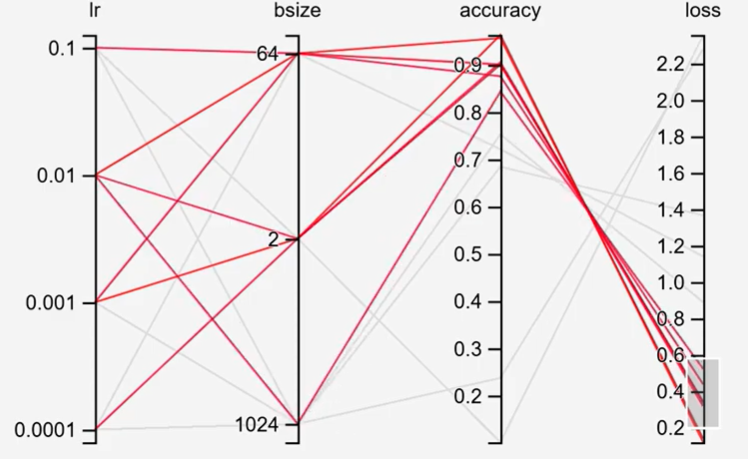

In [64]:
# Hyperparameters
in_channels = 1
num_classes = 10
num_epochs = 1
# To do hyperparameter search::::::::
batch_sizes = [2, 64]
learning_rates = [0.1 , 0.01 ]

In [67]:
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        step = 0   # For Tensor Board
        # Initialize network
        model = CNN(in_channels=in_channels, num_classes=num_classes)
        model.to(device)
        model.train()
        criterion = nn.CrossEntropyLoss()
        train_loader = DataLoader(
            dataset=train_dataset, batch_size=batch_size, shuffle=True
        )
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0)
        writer = SummaryWriter(f"runs/MNIST/MiniBatchSize {batch_size} LR {learning_rate}")


        for epoch in range(num_epochs):
            losses = []
            accuracies = []

            for batch_idx, (data, targets) in tqdm(enumerate(train_loader),total = len(train_loader)):
                # Get data to cuda if possible
                data = data.to(device=device)
                targets = targets.to(device=device)

                # forward
                scores = model(data)
                loss = criterion(scores, targets)
                losses.append(loss.item())

                # backward
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                _, predictions = scores.max(1)
                num_correct = (predictions == targets).sum()
                running_train_acc = float(num_correct) / float(data.shape[0])
                accuracies.append(running_train_acc)

                # Plot things to tensorboard
                writer.add_scalar("Training loss", loss, global_step=step)
                writer.add_scalar("Training Accuracy", running_train_acc, global_step=step                )
                step += 1

            writer.add_hparams( {"lr": learning_rate, "bsize": batch_size},
                                {"accuracy": sum(accuracies) / len(accuracies),
                                "loss": sum(losses) / len(losses)} )

100%|██████████| 938/938 [00:19<00:00, 47.14it/s]


### Example - Visualizing DataSet Images

- Visualzing Images fed to Network During Training

In [74]:
# Hyperparameters
in_channels = 1
num_classes = 10
num_epochs = 1
# To do hyperparameter search::::::::
batch_sizes = [64]
learning_rates = [0.01]

In [76]:
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        step = 0   # For Tensor Board
        # Initialize network
        model = CNN(in_channels=in_channels, num_classes=num_classes)
        model.to(device)
        model.train()
        criterion = nn.CrossEntropyLoss()
        train_loader = DataLoader(
            dataset=train_dataset, batch_size=batch_size, shuffle=True
        )
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0)
        writer = SummaryWriter(f"runs/MNIST/MiniBatchSize {batch_size} LR {learning_rate}")


        for epoch in range(num_epochs):
            losses = []
            accuracies = []

            for batch_idx, (data, targets) in tqdm(enumerate(train_loader),total = len(train_loader)):
                # Get data to cuda if possible
                data = data.to(device=device)
                targets = targets.to(device=device)

                # forward
                scores = model(data)
                loss = criterion(scores, targets)
                losses.append(loss.item())

                # backward
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                img_grid = torchvision.utils.make_grid(data)  #data = images
                writer.add_image("mnist_images", img_grid ,  global_step=step)  #add images grid to tensorboard
                _, predictions = scores.max(1)
                num_correct = (predictions == targets).sum()
                running_train_acc = float(num_correct) / float(data.shape[0])
                accuracies.append(running_train_acc)

                # Plot things to tensorboard
                writer.add_scalar("Training loss", loss, global_step=step)
                writer.add_scalar("Training Accuracy", running_train_acc, global_step=step                )
                step += 1

            writer.add_hparams( {"lr": learning_rate, "bsize": batch_size},
                                {"accuracy": sum(accuracies) / len(accuracies),
                                "loss": sum(losses) / len(losses)} )

100%|██████████| 938/938 [00:50<00:00, 18.43it/s]


### Example - Visualizing Network Weights

- Visualizing How Weights of Network change as we train

In [77]:
model

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)

In [82]:
# Hyperparameters
in_channels = 1
num_classes = 10
num_epochs = 1
# To do hyperparameter search::::::::
batch_sizes = [64]
learning_rates = [0.01]

In [84]:
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        step = 0   # For Tensor Board
        # Initialize network
        model = CNN(in_channels=in_channels, num_classes=num_classes)
        model.to(device)
        model.train()
        criterion = nn.CrossEntropyLoss()
        train_loader = DataLoader(
            dataset=train_dataset, batch_size=batch_size, shuffle=True
        )
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0)
        writer = SummaryWriter(f"runs/MNIST/MiniBatchSize {batch_size} LR {learning_rate}")


        for epoch in range(num_epochs):
            losses = []
            accuracies = []

            for batch_idx, (data, targets) in tqdm(enumerate(train_loader),total = len(train_loader)):
                # Get data to cuda if possible
                data = data.to(device=device)
                targets = targets.to(device=device)

                # forward
                scores = model(data)
                loss = criterion(scores, targets)
                losses.append(loss.item())

                # backward
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                img_grid = torchvision.utils.make_grid(data)  #data = images
                writer.add_image("mnist_images", img_grid ,  global_step=step)  #add images grid to tensorboard
                writer.add_histogram('fc1' , model.fc1.weight,  global_step=step)               
                _, predictions = scores.max(1)
                num_correct = (predictions == targets).sum()
                running_train_acc = float(num_correct) / float(data.shape[0])
                accuracies.append(running_train_acc)

                # Plot things to tensorboard
                writer.add_scalar("Training loss", loss, global_step=step)
                writer.add_scalar("Training Accuracy", running_train_acc, global_step=step                )
                step += 1

            writer.add_hparams( {"lr": learning_rate, "bsize": batch_size},
                                {"accuracy": sum(accuracies) / len(accuracies),
                                "loss": sum(losses) / len(losses)} )

100%|██████████| 938/938 [01:13<00:00, 12.69it/s]


### Example - Embedding Projector (PCA / t-SNE )

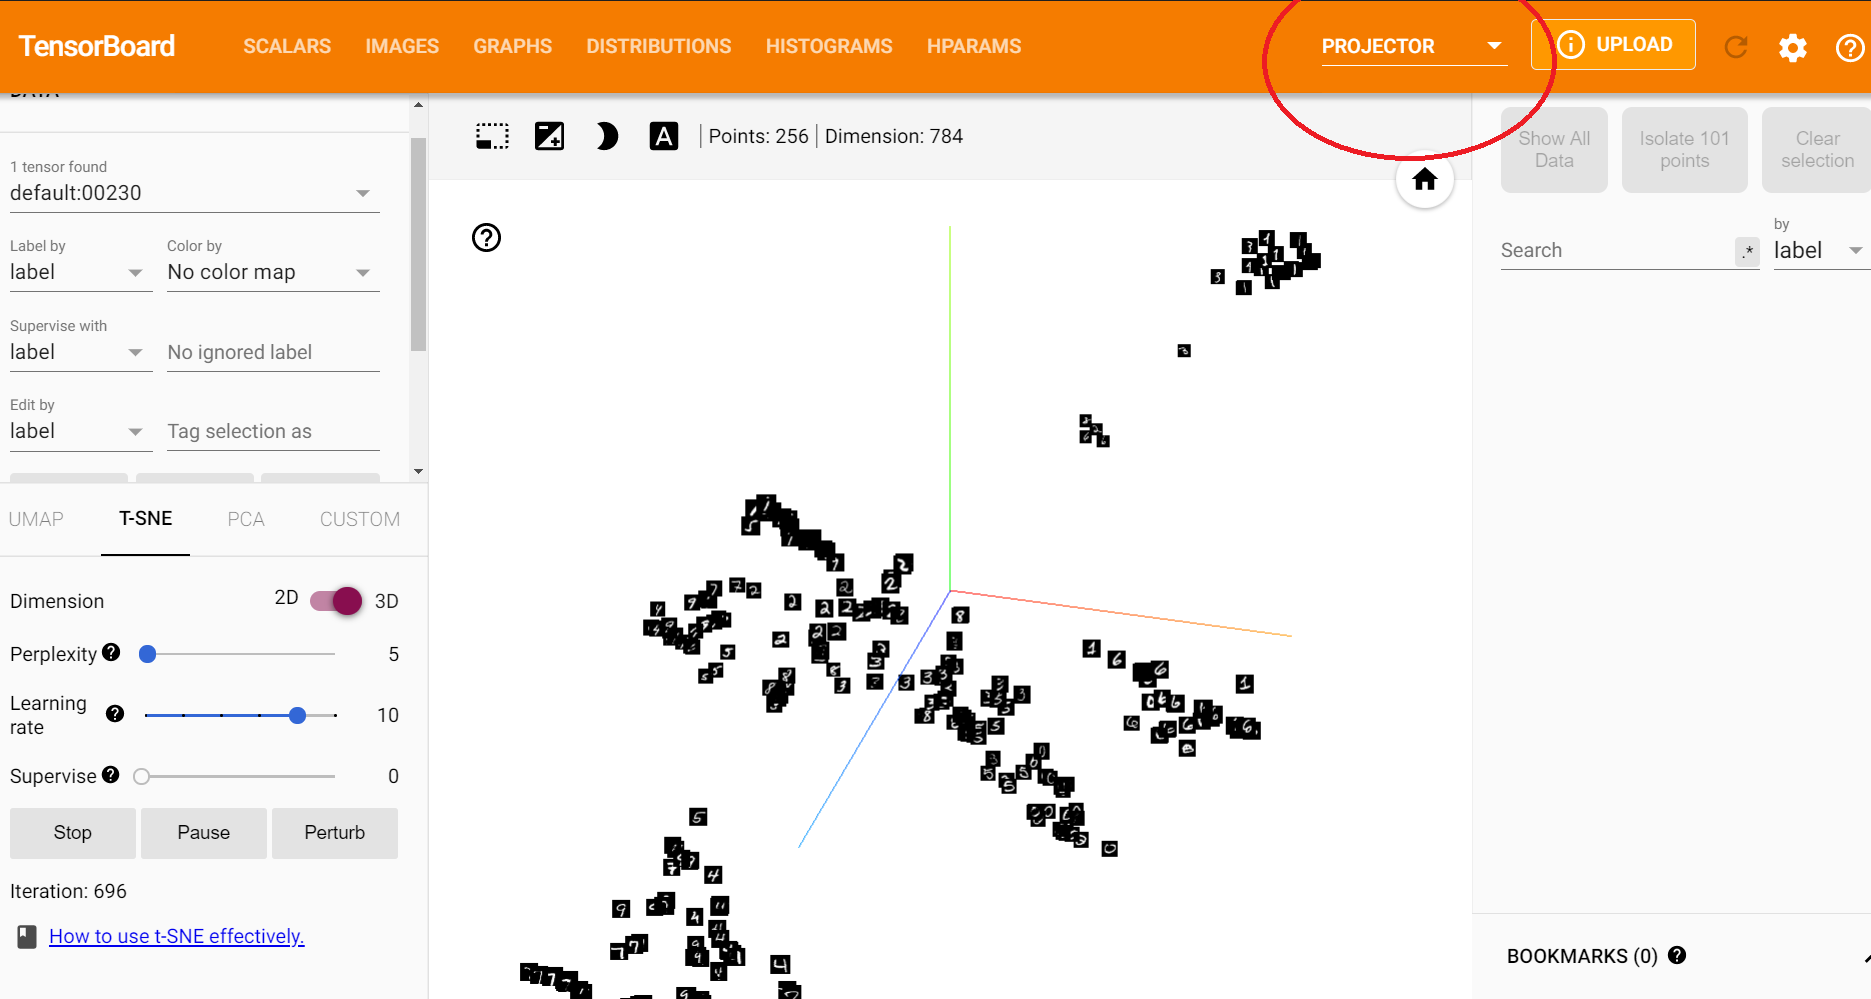

In [109]:
# Hyperparameters
in_channels = 1
num_classes = 10
num_epochs = 1
# To do hyperparameter search::::::::
batch_sizes = [256]
learning_rates = [0.01]

In [110]:
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

In [113]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [114]:
for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        step = 0
        # Initialize network
        model = CNN(in_channels=in_channels, num_classes=num_classes)
        model.to(device)
        model.train()
        criterion = nn.CrossEntropyLoss()
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0)
        writer = SummaryWriter(f"runs/MNIST/MiniBatchSize {batch_size} LR {learning_rate}")

        # Visualize model in TensorBoard
        images, _ = next(iter(train_loader))
        writer.add_graph(model, images.to(device))
        writer.close()

        for epoch in range(num_epochs):
            losses = []
            accuracies = []

            for batch_idx, (data, targets) in enumerate(train_loader):
                # Get data to cuda if possible
                data = data.to(device=device)
                targets = targets.to(device=device)

                # forward
                scores = model(data)
                loss = criterion(scores, targets)
                losses.append(loss.item())

                # backward
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Calculate 'running' training accuracy
                features = data.reshape(data.shape[0], -1)
                img_grid = torchvision.utils.make_grid(data)
                _, predictions = scores.max(1)
                num_correct = (predictions == targets).sum()
                running_train_acc = float(num_correct) / float(data.shape[0])
                accuracies.append(running_train_acc)

                # Plot things to tensorboard
                class_labels = [classes[label] for label in predictions]
                writer.add_image("mnist_images", img_grid)
                writer.add_histogram("fc1", model.fc1.weight)
                writer.add_scalar("Training loss", loss, global_step=step)
                writer.add_scalar("Training Accuracy", running_train_acc, global_step=step)

                if batch_idx == 230:
                    writer.add_embedding(
                        features,
                        metadata=class_labels,
                        label_img=data,
                        global_step=batch_idx,
                    )
                step += 1

            writer.add_hparams(
                              {"lr": learning_rate, "bsize": batch_size},
                              {"accuracy": sum(accuracies) / len(accuracies),
                                "loss": sum(losses) / len(losses),}, )